In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Example: Workshop Data 
In this notebook we go over how to interactively (python) access workshop data and visualize using common python libraries, `matplotlib` and `plotly`. 

## Opening a data file
Data files are stored as a numpy array binary format with an extension `.npz`. Let's open and check what's in the file. Opening is as simple as `numpy.load` function. 

In [2]:
import numpy as np
from __future__ import print_function

# Change if you want to open a different file
DATA_FILE_PATH='/data/hkml_data/E61_3inch/e-/E61_3inch_e-_20-2000MeV_R0cm_100evts_1.npz'

# Open file
f = np.load(DATA_FILE_PATH)

# Print the object type
print (type(f))

<class 'numpy.lib.npyio.NpzFile'>


Like any python object, you can try `help` function call (i.e. `help(f)`) to see what are the attributes (functions and variables). A `NpzFile` instance stores attribute objects by a strig key. You can check what are stored in a pythonic way:

In [3]:
print (f.keys())

['labels', 'event_data']


So we got two objects: `labels` and `event_data`. You probably have a good guess what they are, but let's just look at what `event_data` is:

In [4]:
print (type(f['event_data']))

<type 'numpy.ndarray'>


`numpy` array! so the next natural thing is to check its dimension:

In [5]:
print (f['event_data'].shape)

(100, 88, 168, 2)


As you probably guessed, this is a `numpy` array that contains 100 event images where each event image is 88x168 pixels. Each pixel has 2 channels that stores PMT "PE" and "Time" information in respective order. 

So what about the labels?

In [6]:
print (f['labels'].shape)

(100,)


That's right: these are labels for 100 events, prepared for an **image classification** task (so 1 integer value as a "label" per event).

## Visualizing data
Let's try visualizing 2D event image. Actually, to be pedantic, the stored data is really 3D since time coordinate can be seen as yet another spatial dimension. So, for 2D image visualization, we will ignore the time information and simply plot PE/pmt as a single channel 2D image using `matplotlib`, which is by far the most popular and 101 plotting library in python.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

If you wonder what `%matplotlib inline` means, it's called a _magic_ command in a notebook and this one sets to make matplotlib drawing in the web browser (as opposed to starting a canvas thread and drawing on it in its own window).

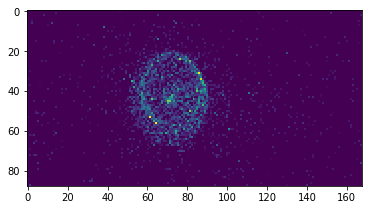

In [8]:
plt.imshow(f['event_data'][0,:,:,0])

Or, maybe make it a bit pretier

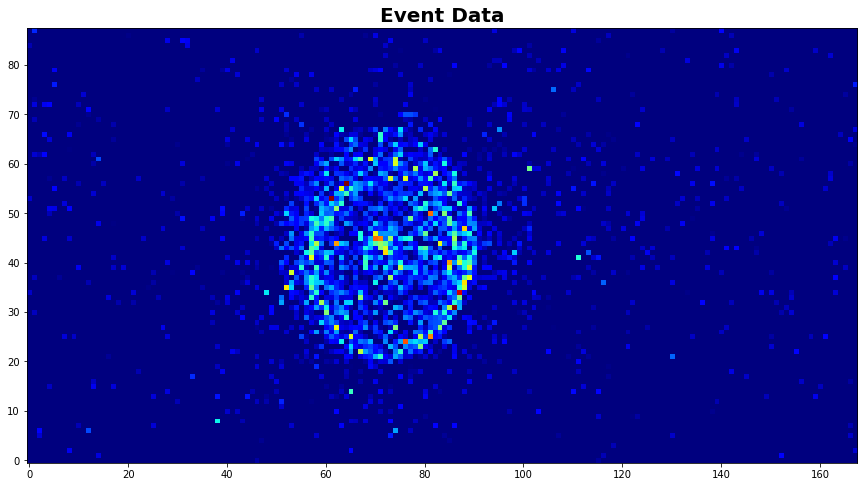

In [9]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(f['event_data'][0,:,:,0],cmap='jet',origin='lower')
ax.set_title('Event Data',fontsize=20,fontweight='bold')
plt.show()

So this image i an overlay of all PMT hits for all time period. Let's try to understand a bit about timing distribution. First, let's just plot time in 1D histogram.

Time in 1D array (14784,) which length should be 88*168 (= 14784 )


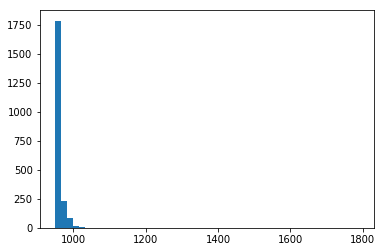

Time min, max, mean are: 948.2999877929688 1790.300048828125 960.1795035356876


In [10]:
# For convenience, let's just make 1D array
time_1d = f['event_data'][0,:,:,1].reshape([-1])
print ('Time in 1D array', time_1d.shape, 'which length should be 88*168 (=', 88*168,')')

# Further, let's filter out to keep only non-zero elements
time_1d = time_1d[time_1d>0]

# Make 1D histogram
_ = plt.hist(time_1d,bins=50)
plt.show()

# Let's print out min, max, mean
print ('Time min, max, mean are:', time_1d.min(), time_1d.max(), time_1d.mean())

The histogram range is automatically set, unless specified, to the min and max value of the data array. The max value 1790 is clearly an outlier, so let's just plot within the range of 950 to 1150.

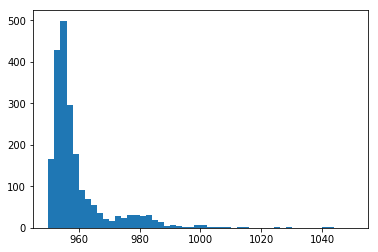

In [11]:
_ = plt.hist(time_1d,bins=50,range=(950,1050))
plt.show()

Pretier?

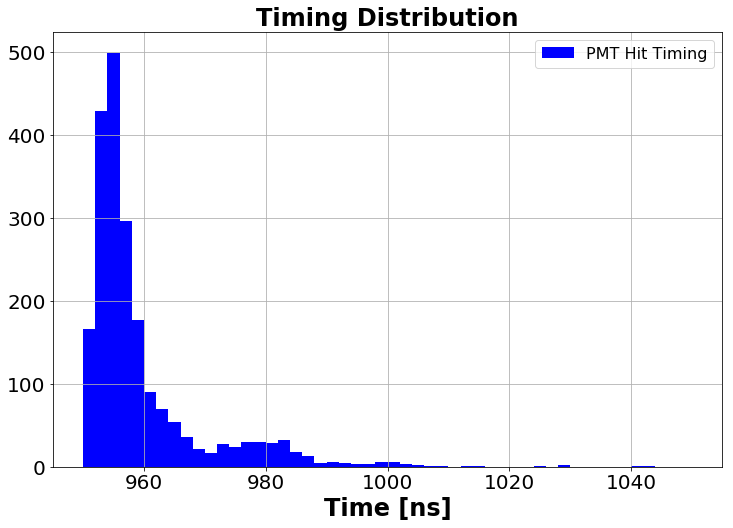

In [12]:
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')

ax.hist(time_1d,bins=50,range=(950,1050),color='blue',label='PMT Hit Timing')
ax.set_title("Timing Distribution",fontsize=24,fontweight='bold')
ax.set_xlabel('Time [ns]',fontsize=24,fontweight='bold')
ax.tick_params('x',labelsize=20)
ax.tick_params('y',labelsize=20)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()

Okay, so the most meaty part of the timing distribution is around 958-ish. There's an interesting bump at 980! Really interesting and makes me want to look at this in 3D. So here comes plotly.

## 3D Visualization
Plotly is a nice tool for an interactive data visualization. The documentation is rich and you can google most of it. Here, I give you my way of visualizing 3D data with my style. Hopefully you can tweak and find the style you like the most.

In [13]:
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [14]:
def plot(data):
    """
        Args: data is 3 dimensional numpy array, the shape should be [Nx,Ny,2] where Nx and Ny are number of pixels along x and y axis of 2D image.
 
        Returns: "trace" object that can be visualized by plotly
    """    
    # Separate PE and Time into 2 separate arrays
    pe = data[:,:,0]
    t  = data[:,:,1]
    # Get non-zero element location
    coords_xy = np.where(pe>0)
    # Get values at non-zero element location
    vals = pe[coords_xy]
    # Define "z" coordinate, which we use Time
    coords_z  = (t[coords_xy]).astype(np.int32)
    # Create a trace object with x, y, and z location values + PE
    trace_3d = go.Scatter3d(x=coords_xy[:][0],y=coords_xy[:][1],z=coords_z,
                            mode='markers',
                            marker = dict(
                                size = 4,
                                color = np.log(vals*100),
                                colorscale='Viridis',
                                opacity=0.7
                            )
                           )
    return trace_3d

def get_layout_3d(ranges,titles):
    layout = go.Layout(
        showlegend=False,
        #xaxis=titles[0], yaxis=titles[1], zaxis=titles[2],
        margin=dict(l=0,r=0,b=0,t=0),        
        scene = dict(
            xaxis = dict(nticks=10, range = ranges[0], showticklabels=True, title=titles[0],
                         backgroundcolor="lightgray", gridcolor="rgb(255, 255, 255)",
                         showbackground=True,
                        ),
            yaxis = dict(nticks=10, range = ranges[1], showticklabels=True, title=titles[1],
                         backgroundcolor="lightgray", gridcolor="rgb(255, 255, 255)",
                         showbackground=True
                        ),
            zaxis = dict(nticks=10, range = ranges[2], showticklabels=True, title=titles[2],
                         backgroundcolor="lightgray", gridcolor="rgb(255, 255, 255)",
                         showbackground=True,
                        ),
            aspectmode='cube',
        ),  
    )
    return layout

In [15]:
# get plotly traces
trace3d = plot(f['event_data'][0])

# visualize 3d
ranges=((0.,88.),(0.,168.),(950.,1050.))
layout = get_layout_3d(ranges,['PMT (vert)','PMT (hori)','Time'])
fig = go.Figure(data=[trace3d],layout=layout)
iplot(fig,filename='my 3d plot')

We can see a nice convex surface in 3D! This is the end of data access and visualization tutorial. If you have concerns/questions/suggestions, [please share](mailto:kterao@slac.stanford.edu).